# Implementing Linear Regression with Gradient Descent From Scratch
In this notebook, we will:
* Learn how to derive and build a gradient descent algorithm for linear regression using primarily `numpy`.
* Compare the results yield by the least square method with those by the gradient descent algorithm.


## Dataset
The dataset used in this notebook is extracted from the textbook namely **Applied Statistics and Probability for Engineers (7th Edition)** by Montgomery et al.; the dataset is in Chapter 1, p.13 and p.14. The data in this dataset were collected in an observational study in a semiconductor manufacturing plant. The variables reported in this dataset are **pull strength**, **wire length**, and **die height**. The objective of this study is to predict the pull strength, which is closely related to the bond strength, based on the length of the wire and the height of the die. By investigating the bond strength, engineers can evaluate bond failure modalities or determine compliance with specified bond strength requirements, for instance the MIL-STD-810G standard.



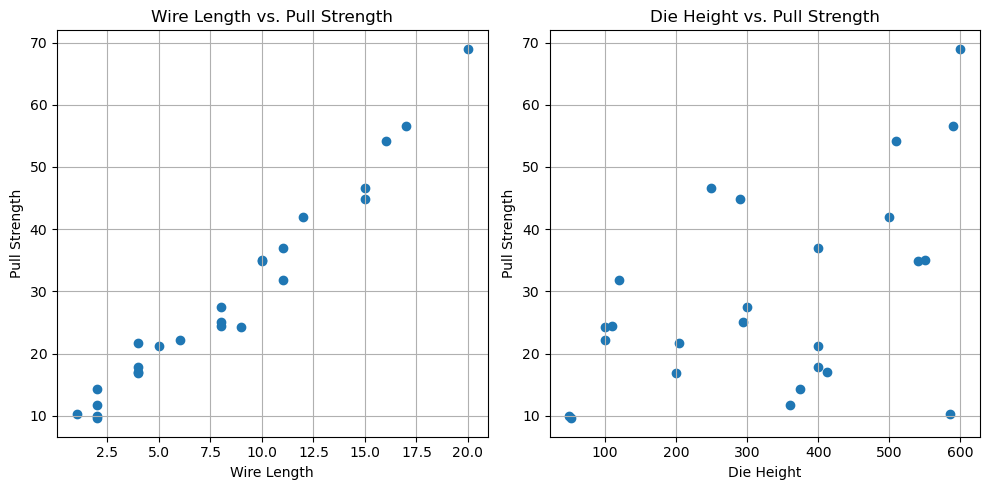

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

##
# Load the dataset:
#
dataframe = pd.read_csv("../linear-regression/dataset/wirepullstrength.csv")
X1 = dataframe["Wire Length"]
X2 = dataframe["Die Height"]
Y = dataframe["Pull Strength"]

##
# Visualize the dataset:
#
fig, axs = plt.subplots(1,2, figsize = (10,5), dpi = 100)
axs[0].scatter(X1, Y)
axs[0].set_title('Wire Length vs. Pull Strength')
axs[0].set_xlabel('Wire Length')
axs[0].set_ylabel('Pull Strength')
axs[0].grid(True)

axs[1].scatter(X2, Y)
axs[1].set_title('Die Height vs. Pull Strength')
axs[1].set_xlabel('Die Height')
axs[1].set_ylabel('Pull Strength')
axs[1].grid(True)

fig.tight_layout()
plt.show()

## Least Square Method
### Backgrounds
Consider a simple dataset of $n$ observations ($\mathbf{x} = \{x_i\}, \mathbf{y} = \{y_i\} \text{  } \forall i = \{1,2,3,...,n\}$) where $\mathbf{x}$ is an independent variable, $\mathbf{y}$ is a dependent variable, and both $\mathbf{x}$ and $\mathbf{y}$ are column vectors. To describe the linear relationship between $\mathbf{x}$ and $\mathbf{y}$, we use the following model $\mathbf{y} = \beta_0 + \beta_1\mathbf{x}$, where $\beta_0$ and $\beta_1$ are the parameters of the linear model.

Our goal is to find the values of $\beta_0$ and $\beta_1$ such that the model fits the data the best. In other words, we want to find the values of $\beta_0$ and $\beta_1$ such that the difference between the observed values of the dependent variable and the values predicted by the model, also know as the residual, is the smallest:
$$
\text{min} \quad |(\beta_0 + \beta_1\mathbf{x}) - \mathbf{y}|
$$

Let $F(\beta_0, \beta_1) = |(\beta_0 + \beta_1\mathbf{x}) - \mathbf{y}|$ be the function that describes the difference between the observed values of the dependent variable and the values predicted by the model. Clearly $F(\beta_0, \beta_1)$ is a piecewise function, which is surprising difficult to find the extrema. Hence, we usually transform the function $F$ to a function denoted as $J$ such that:
$$
J(\beta_0, \beta_1) = F^2 = \Big( (\beta_0 + \beta_1\mathbf{x}) - \mathbf{y} \Big)^2
$$

As a result, we can easily find the values $\beta_0$ and $\beta_1$ that yields the smallest residual by finding the extrema of $J(\beta_0, \beta_1)$ via first-order and second-order partial derivatives:
* First-order:
$$
\begin{aligned}
\frac{\partial J(\beta_0, \beta_1)}{\partial \beta_0} &= 2\Big( (\beta_0 + \beta_1\mathbf{x}) - \mathbf{y} \Big) = 2\beta_0 + 2\beta_1\mathbf{x} - 2\mathbf{y} \\
\frac{\partial J(\beta_0, \beta_1)}{\partial \beta_0} &= 0 \iff \beta_0 = \mathbf{y} - \beta_1\mathbf{x} \\
\end{aligned}
$$

$$
\begin{aligned}
\frac{\partial J(\beta_0, \beta_1)}{\partial \beta_1} &= 2\Big( (\beta_0 + \beta_1\mathbf{x}) - \mathbf{y} \Big)\mathbf{x} = 2\mathbf{x}\beta_0 + 2\mathbf{x}^2\beta_1 - 2\mathbf{x}\mathbf{y}\\
\frac{\partial J(\beta_0, \beta_1)}{\partial \beta_1} &= 0 \iff \beta_1 = \frac{\mathbf{x}\mathbf{y} - \beta_0\mathbf{x}}{\mathbf{x^2}}\\
\end{aligned}
$$

* Second-order:
$$
\begin{aligned}
\frac{\partial^2 J(\beta_0, \beta_1)}{\partial^2 \beta_0} &= 2 > 0 \quad \forall \beta_0 \in \mathbb{R} \rightarrow \text{concave up}
\end{aligned}
$$

$$
\begin{aligned}
\frac{\partial^2 J(\beta_0, \beta_1)}{\partial^2 \beta_1} &= 2\mathbf{x}^2 > 0 \quad \forall \beta_1 \in \mathbb{R} \rightarrow \text{concave up}
\end{aligned}
$$


### Formulas
For n-dimensional data ($\mathbf{X}, \mathbf{Y} \in \mathbb{R}^{m\times n}$):

$$
\begin{aligned}
\mathbf{Y} &= \beta_0 + \beta_1\mathbf{X} \\
\beta_1 &= (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{Y} \\
\beta_0 &= E[\mathbf{Y}] - \beta_1\mathbf{X}
\end{aligned}
$$

For 1-dimensional data ($\mathbf{x}, \mathbf{y} \in \mathbb{R}^{m}$):
$$
\begin{aligned}
\mathbf{y} &= \beta_0 + \beta_1\mathbf{x} \\
\beta_1 &= \frac{\sum_{i = 1}^m (x_i - \bar{x})(y_i - \bar{y})}{\sum_{i = 1}^m (x_i - \bar{x})^2} \\
\beta_0 &= \bar{y} - \beta_1\bar{x}
\end{aligned}
$$

Below is how the least square method is applied to find parameters of the model for our aforemetioned dataset.

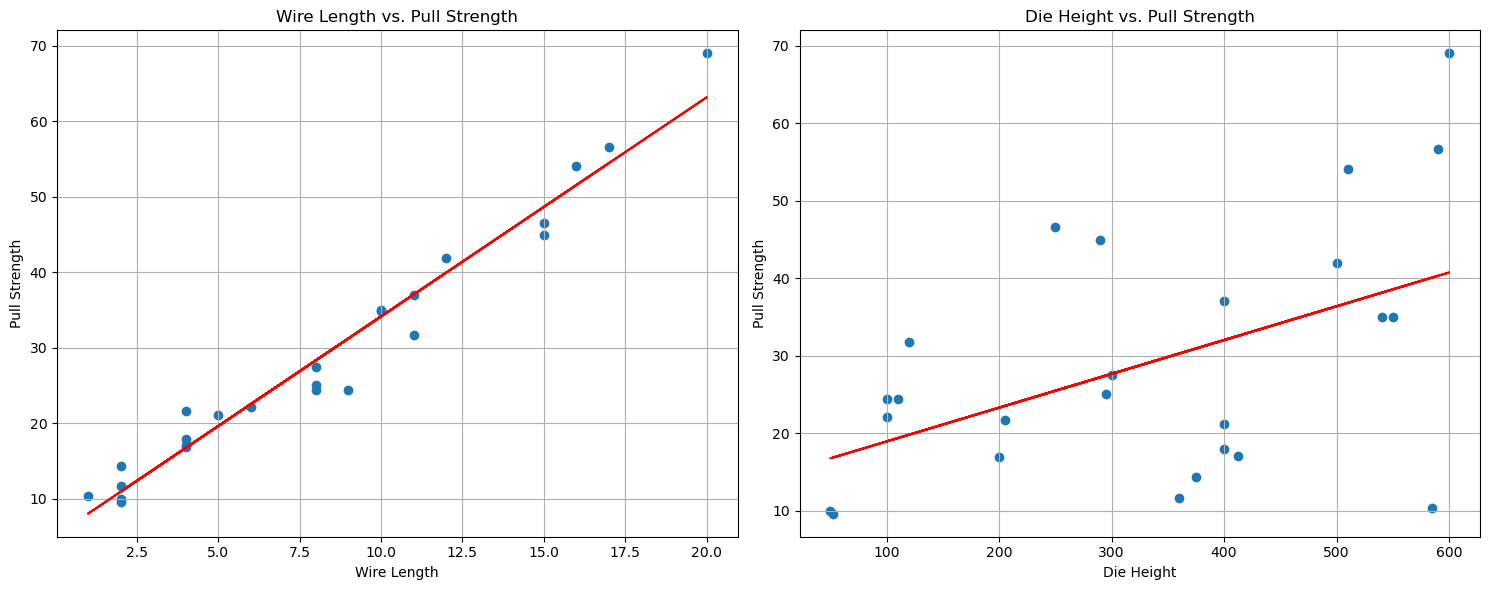

In [2]:
##
# Simple Linear Regression Using Least Square Method (1-dimensional):
#
def one_dimensional_least_square(X, Y):
    """
    Compute parameters of the least square linear model.
    """
    numerator = np.dot([(x - np.mean(X)) for x in X], [(y - np.mean(Y)) for y in Y])
    denominator = np.sum([(x - np.mean(X)) ** 2 for x in X])
    beta_1 = numerator / denominator
    beta_0 = np.mean(Y) - beta_1 * np.mean(X)
    return beta_0, beta_1

beta_0_X1, beta_1_X1 = one_dimensional_least_square(X1, Y)
Yhat_1 = beta_0_X1 + beta_1_X1 * X1
f1 = lambda x: beta_0_X1 + beta_1_X1 * x

beta_0_X2, beta_1_X2 = one_dimensional_least_square(X2, Y)
Yhat_2 = beta_0_X2 + beta_1_X2 * X2
f2 = lambda x: beta_0_X2 + beta_1_X2 * x

fig, axs = plt.subplots(1,2, figsize = (15,6), dpi = 100)
axs[0].scatter(X1, Y)
axs[0].plot(X1, f1(X1), color = 'red')
axs[0].set_title('Wire Length vs. Pull Strength')
axs[0].set_xlabel('Wire Length')
axs[0].set_ylabel('Pull Strength')
axs[0].grid(True)

axs[1].scatter(X2, Y)
axs[1].plot(X2, f2(X2), color = 'red')
axs[1].set_title('Die Height vs. Pull Strength')
axs[1].set_xlabel('Die Height')
axs[1].set_ylabel('Pull Strength')
axs[1].grid(True)

fig.tight_layout()
plt.show()

## Gradient Descent Method
### Backgrounds
Gradient descent is a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. In this scenario, the function that we are interested in is the mean of squared residuals:
$$
\frac{1}{m}\sum_{i = 1}^m(\beta_0 + \beta_1x_i - y_i)^2
$$

In practice, this function will be scaled by a factor of $\frac{1}{2}$ since it makes the differentiation task easier:
$$
\text{min} \quad J(\beta_0, \beta_1) = \frac{1}{2m}\sum_{i = 1}^m(\beta_0 + \beta_1x_i - y_i)^2
$$
with $J(\beta_0, \beta_1)$ is the cost function, a.k.a. the function that we want to find the local mininum. 

The gradient descent algorithm has the following steps:
* Step 1: initialize $\beta_0$ and $\beta_1$. The intial values of the parameters $\beta_1$ and $\beta_0$ are usually drawn from a truncated normal distribution with zero mean and a specific standard deviation $\mathcal{N}(0, \sigma = \sqrt{\frac{2}{m}})$
* Step 2: compute the gradient of the loss function in respect to $\beta_0$ and $\beta_1$. In this scenario, the loss function is the mean of squared residuals:
$$
\begin{aligned}
\nabla_{\beta_1} &= \frac{1}{m}\sum_{i=1}^m(\beta_0 + \beta_1x_i - y_i)(x_i) \\
\nabla_{\beta_0} &= \frac{1}{m}\sum_{i=1}^m(\beta_0 + \beta_1x_i - y_i) \\
\end{aligned}
$$
* Step 3: update $\beta_0$ and $\beta_1$ iteratively. The parameters at the $k + 1$ iteration equal to the parameters at the $k$ iteration minus the learning step, which is the product of the learning rate $\eta$ and the gradients.
$$
\begin{aligned}
\beta_1^{k+1} &= \beta_1^{k} - \eta\nabla_{\beta_1}  \\
\beta_0^{k+1} &= \beta_0^{k} - \eta\nabla_{\beta_0}  \\
\end{aligned}
$$

Below is how the gradient descent method is used to find parameters of the linear model for our aforementioned dataset.

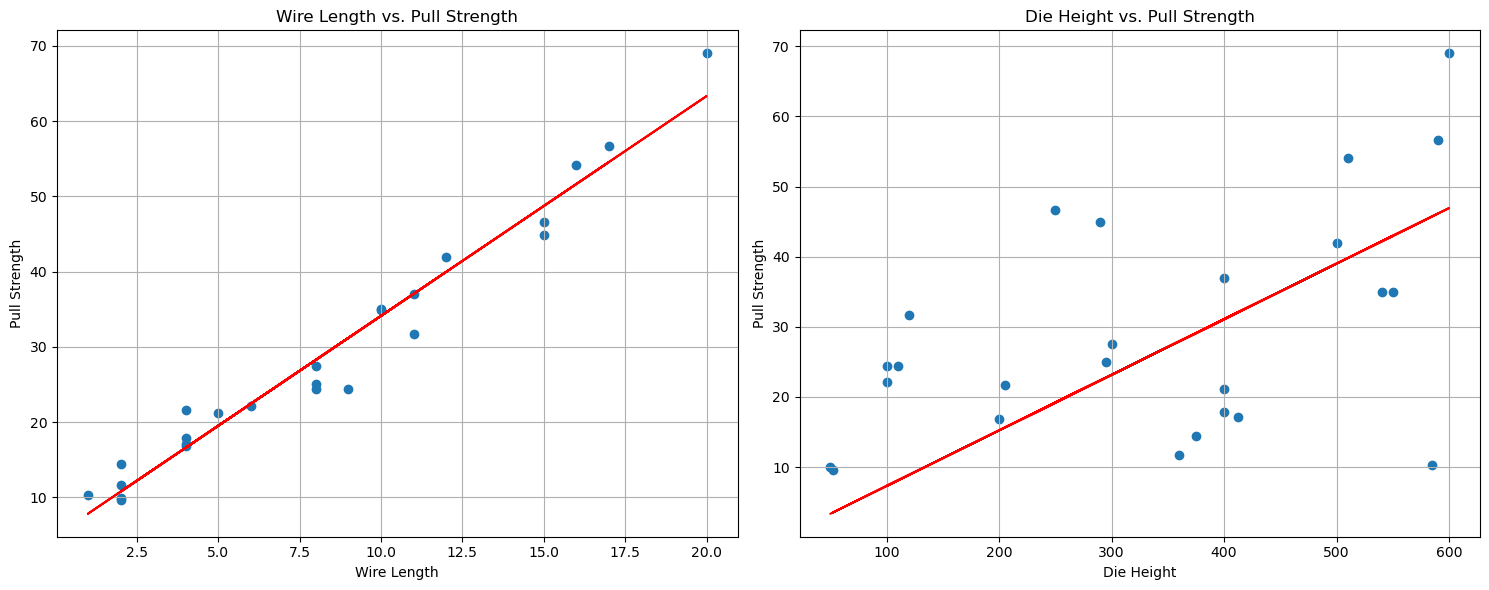

In [3]:
##
# Simple linear regression using gradient descent:
#
def initializer(X, Y, type = 'he_norm'):
  """
  Initializes the weights of a linear regression model.
  """
  if type == 'zero':
    weight = np.zeros(Y.shape[0])
  elif type == 'he_norm':
    weight = np.random.normal(loc = 0, scale = np.sqrt(2 / len(Y)))
  else:
    raise ValueError('Invalid initialization type: {}'.format(type))

  return weight

def compute_gradients(X, Y, beta_0, beta_1):
  """
  Computes the gradients of the loss function with respect to the weights of a
  linear regression model.
  """
  L = 1 / (2 * len(Y)) * ((beta_0 + beta_1 * X) - Y)**2
  dLdb1 = np.clip(1 / len(Y) * np.dot((beta_0 + beta_1 * X) - Y, X), a_max = 100, a_min = -100)
  dLdb0 = np.clip(1 / len(Y) * np.sum((beta_0 + beta_1 * X) - Y), a_max = 100, a_min = -100)
  
  return dLdb0, dLdb1, L

def gradient_descent(X, Y, lr, num_iter):
  """
  Trains a linear regression model using gradient descent.
  """

  beta_0 = initializer(X, Y, type = 'he_norm')
  beta_1 = initializer(X, Y, type = 'he_norm')

  for i in range(num_iter + 1):
    dLdb0, dLdb1, L = compute_gradients(X, Y, beta_0, beta_1)
    beta_0 -= lr * dLdb0
    beta_1 -= lr * dLdb1

  return beta_0, beta_1

beta_0_X1, beta_1_X1 = gradient_descent(X1, Y, lr = 0.01, num_iter = 1000)
f1 = lambda x: beta_0_X1 + beta_1_X1 * x

beta_0_X2, beta_1_X2 = gradient_descent(X2, Y, lr = 0.00001, num_iter = 1000)
f2 = lambda x: beta_0_X2 + beta_1_X2 * x

fig, axs = plt.subplots(1,2, figsize = (15,6), dpi = 100)
axs[0].scatter(X1, Y)
axs[0].plot(X1, f1(X1), color = 'red')
axs[0].set_title('Wire Length vs. Pull Strength')
axs[0].set_xlabel('Wire Length')
axs[0].set_ylabel('Pull Strength')
axs[0].grid(True)

axs[1].scatter(X2, Y)
axs[1].plot(X2, f2(X2), color = 'red')
axs[1].set_title('Die Height vs. Pull Strength')
axs[1].set_xlabel('Die Height')
axs[1].set_ylabel('Pull Strength')
axs[1].grid(True)

fig.tight_layout()
plt.show()